In [4]:
import numpy as np
import pandas as pd

import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,f_oneway,kruskal

import re
import warnings
# import ('../../../utils.py')
warnings.filterwarnings('ignore')


# Utils

## Functions

### Feature Selection

In [5]:

def get_pvalue_dict(df,label_cols,unwanted_cols=[]):
    
    # delete unwanted
    colnames = df.columns
    colnames = list(set(colnames)-set(label_cols)-set(unwanted_cols))
    classes=list(dict(sorted(dict(df.value_counts(label_cols[0])).items())).keys())
    print(classes)
    pvalue_dict={}
    if(len(classes)>2):
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                tmp_feature = df.loc[(df[label_cols[0]] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = kruskal(*class_features)
            pvalue_dict[colname]=p_value
    else:
        for i,colname in enumerate(colnames):
            class_features=[]
            df=df.astype({colname:float})
            for label in classes:
                tmp_feature=[]
                # tmp_feature = df.loc[(df[label_cols[0]] == label)]
                tmp_feature = df.loc[(df[label_cols[0]] == label)].loc[:, colname].tolist()
                class_features.append(tmp_feature)

            _, p_value = mannwhitneyu(*class_features)
            pvalue_dict[colname]=p_value
        
    return pvalue_dict


# Analysis

## 20240419

In [10]:
sample_df=pd.read_csv('../../Subtype/results/20240406/cluster_7e-2.csv',index_col=0)
sample_df

,nmf_3_clusters,kmeans_3_clusters,nmf_2_clusters,kmeans_2_clusters
1452,1,1,1,2
8339,1,1,1,2
5608,1,1,1,2
8232,3,3,2,1
8775,2,3,2,1
...,...,...,...,...
140143-T,1,2,1,2
190040-T,1,2,1,2
190161-T,3,2,2,2
200288-T,3,2,2,1


### RNA seq

In [9]:
rna_df=pd.read_csv('../data/rna/genes.csv',index_col=0)
print(rna_df.shape)
print(rna_df.columns)
rna_df=rna_df.reset_index().rename(columns={'cccc':'Sample Name'}).set_index('Sample Name')

# Rename columns
pattern = r"[Ca|T]([\d]+)"
new_columns=[]
for colname in rna_df.columns:
    id_string=re.search(pattern,colname).group(1)
    if 'T' in colname:
        new_colname=str(id_string)+'-T'
    else:
        new_colname=str(id_string)
    new_columns.append(new_colname)
new_columns
rna_df.rename(columns=dict(zip(rna_df.columns,new_columns)),inplace=True)
rna_df=rna_df.T
rna_df.astype(int)

print(f"data size is {rna_df.shape}")


(58818, 111)
Index(['count.Ca1277', 'count.Ca1364', 'count.Ca1452', 'count.Ca1520',
       'count.Ca1649', 'count.Ca1775', 'count.Ca1870', 'count.Ca1900',
       'count.Ca2039', 'count.Ca2139',
       ...
       'count.T200095', 'count.T200097', 'count.T200128', 'count.T200131',
       'count.T200288', 'count.T200297', 'count.T210011', 'count.T210012',
       'count.T222836', 'count.T271431'],
      dtype='object', length=111)
data size is (111, 58818)


In [10]:
counts_df=rna_df.copy(deep=True)

In [11]:
display(counts_df.head())
rna_df.dtypes

Sample Name,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288634,ENSG00000288635,ENSG00000288636,ENSG00000288637,ENSG00000288638,ENSG00000288639,ENSG00000288640,ENSG00000288642,ENSG00000288644,ENSG00000288645
1277,77,0,19,125,38,96,0,50,492,0,...,2,0,1,5,0,0,0,7,0,0
1364,1443,0,942,1420,1792,112,241,1240,1482,1638,...,1,0,0,97,191,0,0,0,1,1
1452,297,7,712,1323,1901,141,252,930,249,2249,...,1,0,0,200,393,0,142,0,1,4
1520,1102,22,841,1968,1588,2029,4576,2183,2601,3123,...,1,0,0,87,3,0,80,0,1,1
1649,531,5,998,1889,2306,296,136,483,1567,2317,...,1,3,0,257,85,0,0,0,1,1


Sample Name
ENSG00000000003    int64
ENSG00000000005    int64
ENSG00000000419    int64
ENSG00000000457    int64
ENSG00000000460    int64
                   ...  
ENSG00000288639    int64
ENSG00000288640    int64
ENSG00000288642    int64
ENSG00000288644    int64
ENSG00000288645    int64
Length: 58818, dtype: object

In [9]:
sample_indexes=list(set(rna_df.index)&set(sample_df.index))

NameError: name 'rna_df' is not defined

#### Prepare Data

In [44]:
print(f"data size is {counts_df.shape}")
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]
counts_df=counts_df.loc[sample_indexes]
counts_sample_df=sample_df.loc[sample_indexes]
print(f"data size is {counts_df.shape}")



data size is (92, 55559)
data size is (92, 55559)


In [45]:
# Replace with your actual sample information (e.g., control vs. treatment)
condition_series = sample_df.loc[:,['kmeans_2_clusters']]


In [48]:
inference = DefaultInference(n_cpus=32)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=counts_sample_df,
    design_factors="kmeans_2_clusters",
    refit_cooks=True,
    inference=inference,
)
# Create a DESeq2 dataset (DESeqDataSet)


In [49]:
dds.deseq2()


Fitting size factors...
... done in 0.13 seconds.

Fitting dispersions...
... done in 6.68 seconds.

Fitting dispersion trend curve...
... done in 1.24 seconds.

Fitting MAP dispersions...
... done in 7.56 seconds.

Fitting LFCs...
... done in 5.23 seconds.

Replacing 6996 outlier genes.

Fitting dispersions...
... done in 1.07 seconds.

Fitting MAP dispersions...
... done in 1.13 seconds.

Fitting LFCs...
... done in 1.00 seconds.



In [54]:
stat_res = DeseqStats(dds, inference=inference)


Running Wald tests...
... done in 3.25 seconds.



Log2 fold change & Wald test p-value: kmeans-2-clusters 2 vs 1
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Sample Name                                                                  
ENSG00000000003  1115.117110       -0.119829  0.233119 -0.514025  0.607235   
ENSG00000000005     9.959599       -0.085123  0.438662 -0.194052  0.846135   
ENSG00000000419   599.428725       -0.033217  0.169014 -0.196536  0.844191   
ENSG00000000457  1556.931533        0.055492  0.124243  0.446642  0.655134   
ENSG00000000460  1784.631575        0.270922  0.192261  1.409137  0.158795   
...                      ...             ...       ...       ...       ...   
ENSG00000288639     0.350525        0.090470  0.594432  0.152196  0.879033   
ENSG00000288640    29.263922       -1.534772  1.258796 -1.219238  0.222754   
ENSG00000288642     0.287546        1.095881  2.973333  0.368570  0.712448   
ENSG00000288644     0.916655        0.077369  0.329447  0.234846  0.814328   
E

In [60]:
rna_stat_result_df=stat_res.results_df
rna_stat_result_df.to_csv('../results/20240419/rna_stat.csv')

In [61]:
rna_sd_df=rna_stat_result_df[(abs(rna_stat_result_df['log2FoldChange'])>=1)&(rna_stat_result_df['padj']<=5e-2)]


In [63]:
for i in rna_sd_df.index:
    print(i)

ENSG00000000971
ENSG00000003400
ENSG00000003436
ENSG00000004468
ENSG00000004846
ENSG00000004848
ENSG00000005001
ENSG00000005844
ENSG00000006283
ENSG00000006377
ENSG00000007129
ENSG00000007216
ENSG00000007312
ENSG00000007372
ENSG00000008517
ENSG00000009790
ENSG00000010295
ENSG00000010610
ENSG00000010671
ENSG00000010932
ENSG00000011332
ENSG00000012124
ENSG00000012223
ENSG00000013588
ENSG00000013725
ENSG00000014257
ENSG00000017427
ENSG00000018280
ENSG00000019186
ENSG00000019582
ENSG00000023445
ENSG00000026103
ENSG00000026751
ENSG00000026950
ENSG00000029559
ENSG00000035720
ENSG00000036448
ENSG00000037280
ENSG00000041515
ENSG00000043462
ENSG00000047457
ENSG00000047936
ENSG00000049089
ENSG00000049249
ENSG00000050438
ENSG00000050730
ENSG00000054179
ENSG00000054219
ENSG00000055813
ENSG00000057657
ENSG00000058335
ENSG00000060140
ENSG00000060718
ENSG00000061656
ENSG00000062716
ENSG00000063515
ENSG00000064886
ENSG00000065833
ENSG00000066230
ENSG00000066294
ENSG00000067066
ENSG00000067840
ENSG0000

In [51]:
print(dds)


AnnData object with n_obs × n_vars = 92 × 55559
    obs: 'nmf_3_clusters', 'kmeans_3_clusters', 'nmf_2_clusters', 'kmeans-2-clusters'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'replace_cooks'


In [50]:

# Perform library size normalization
dds = dds.normalize()


AttributeError: 'DeseqDataSet' object has no attribute 'normalize'

### Metab

#### Prepare Data

In [11]:
name_map_df=pd.read_csv('../data/kegg/kegg_name_map.csv')
name_map_df['compound']=name_map_df['compound'].str.lower()
name_map_df['match']=name_map_df['Match'].str.lower()

In [12]:
metab_df=pd.read_csv('../../Subtype/data/Using/metab.csv',index_col=0)
metab_df=metab_df.rename(columns=dict(zip(metab_df.columns,metab_df.columns.str.lower())))

In [13]:
using_df=pd.merge(metab_df,sample_df.loc[:,['kmeans_2_clusters']],left_index=True,right_index=True)

In [14]:
metab_stat_df=pd.DataFrame.from_dict(get_pvalue_dict(using_df,['kmeans_2_clusters']),orient='index',columns=['pvalue'])

[1, 2]


In [15]:
name_map_df['compound']

0                  urea
1          ethanolamine
2               glycine
3               alanine
4      betaine aldehyde
             ...       
273       dephospho-coa
274               nadp+
275               nadp+
276               nadph
277               nadph
Name: compound, Length: 278, dtype: object

In [16]:
# metab_stat_df.to_csv('../results/20240419/metab_stat.csv')

#### Unfindable
- 2-hydroxygluterate 
    - 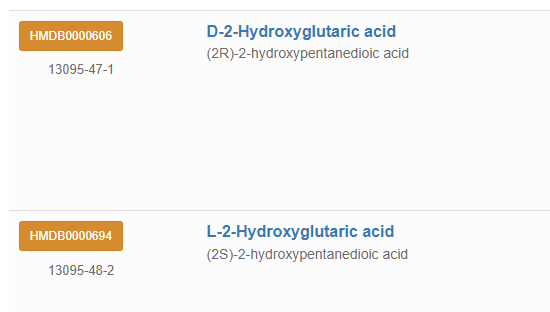
    - D-2-Hydroxyglutaric acid HMDB0000606
    - L-2-Hydroxyglutaric acid HMDB0000694
- d-sedoheptulose-1-7-phosphate
    - HMDB0304323
- 2-deoxyglucose-6-phosphate
- hexose-phosphate
    - Glucose 6-phosphate HMDB0001401




In [18]:
unfind_metab_compounds=['2-hydroxygluterate','d-sedoheptulose-1-7-phosphate','hexose-phosphate']
unfind_metab_hmdbs=['HMDB0000606','HMDB0304323','HMDB0001401']
for index in range(len(unfind_metab_compounds)):
    new_row={'compound':unfind_metab_compounds[index],'HMDB':unfind_metab_hmdbs[index]}
    name_map_df = pd.concat([name_map_df, pd.DataFrame([new_row])], ignore_index=True)


In [19]:
# Unfindable
for i in metab_stat_df[metab_stat_df['pvalue']<=5e-2].index:
    i=i.replace("_pos","")
    i=i.replace("_neg","")
    if len(name_map_df[name_map_df['compound']==i].HMDB.values)==0:
        if len(name_map_df[name_map_df['match']==i].HMDB.values)==0:
            print(i)
    
    # print(name_map_df[name_map_df['compound']==i].HMDB.values[0])

2-deoxyglucose-6-phosphate


#### Result 

In [20]:
for i in metab_stat_df[metab_stat_df['pvalue']<=5e-2].index:
    i=i.replace("_pos","")
    i=i.replace("_neg","")
    if len(name_map_df[name_map_df['compound']==i].HMDB.values)==0:
        if len(name_map_df[name_map_df['match']==i].HMDB.values)==0:
            # print(i)
            continue
        else:
            print(name_map_df[name_map_df['match']==i].HMDB.values[0])
            continue
    else:
        print(name_map_df[name_map_df['compound']==i].HMDB.values[0])
    
    # print(name_map_df[name_map_df['compound']==i].HMDB.values[0])

HMDB0000939
HMDB0001185
HMDB0000201
HMDB0000263
HMDB0001406
HMDB0001864
HMDB0000128
HMDB0000085
HMDB0000099
HMDB0000779
HMDB0000271
HMDB0001494
HMDB0000058
HMDB0001227
HMDB0001473
HMDB0000045
HMDB0000294
HMDB0001321
HMDB0000630
HMDB0001409
HMDB0000133
HMDB0000034
HMDB0000167
HMDB0000446
HMDB0000606
HMDB0000060
HMDB0001206
HMDB0000299
HMDB0000904
HMDB0240251
HMDB0000684
HMDB0000190
HMDB0001413
HMDB0000210
HMDB0001548
HMDB0001316
HMDB0304323
HMDB0000939
HMDB0000175
HMDB0000905
HMDB0001058
HMDB0001440
HMDB0000115
HMDB0000232
HMDB0001112
HMDB0000043
HMDB0000929
HMDB0000653
HMDB0003011
HMDB0001202
HMDB0000292
HMDB0000124
HMDB0000089
HMDB0000157
HMDB0001396
HMDB0000195
HMDB0001367
HMDB0000229
HMDB0000807
HMDB0000742
HMDB0001423
HMDB0000161
HMDB0000538
HMDB0001248
HMDB0000645
HMDB0001401
HMDB0001401
HMDB0001397
HMDB0000296
HMDB0000285


In [ ]:
sample_indexes=list(set(rna_df.index)&set(sample_df.index))